# Proof-of-concept: Muse cube ingestion to InfluxDB

In [23]:
import os
import re
import time
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

mainpath = '/Users/jorgetil/Astro/HITS'

In [28]:
def give_me_lc(field, CCD, X, Y, extract=False):
    year = field[:-3]
    try:
        tar = tarfile.open("%s/lightcurves/%s/%s/%s/%s_%s_LC_50.tar.gz" 
                           % (mainpath, year, field, CCD, field, CCD))
        fil = tar.extractfile('%s_%s_%s_%s_g.dat' % (field, CCD, X, Y))
        if extract:
            tar.extract('%s_%s_%s_%s_g.dat' % (field, CCD, X, Y),
                    path='/Users/jorgetil/Astro/HITS/lightcurves/samples/.')
    except:
        print 'No tar file or element in tar file'
        return None
    
    time, mag, err = [], [], []
    for line in fil:
        if line[0] == '#': continue
        values = line.split()
        time.append(float(values[1]))
        mag.append(float(values[2]))
        err.append(float(values[3]))
    time = np.asarray(time)
    mag= np.asarray(mag)
    err = np.asarray(err)
    
    try:
        fil = tar.extractfile('%s_%s_%s_%s_r.dat' % (field, CCD, X, Y))
        #tar.extract('%s_%s_%s_%s_r.dat' % (field, CCD, X, Y)
        #                , path='/Users/jorgetil/Downloads/.')
        time2, mag2, err2 = [], [], []
        for line in fil:
            if line[0] == '#': continue
            values = line.split()
            time2.append(float(values[1]))
            mag2.append(float(values[2]))
            err2.append(float(values[3]))
        time2 = np.asarray(time2)
        mag2 = np.asarray(mag2)
        err2 = np.asarray(err2)
        return time, mag, err, time2, mag2, err2
    except:
        print 'No lightcurve for other filter'
        return time, mag, err, None, None, None

In [29]:
# load feature table into DF
table_file = '%s/tables/Blind15A_label_sample_new_PS.csv' % (mainpath)
table_15 = pd.read_csv(table_file)
table_15.set_index('internalID', inplace=True)

In [30]:
rrlyr = table_15.query('Var_Type == "RRLYR"')
rrlyr.head(5)

,raMedian,decMedian,spCl,subClass,Var_Type,Var_subType,Amplitude,AndersonDarling,Autocor_length,Beyond1Std,...,Rcs,Skew,SlottedA_length,SmallKurtosis,Std,StetsonK,StetsonK_AC,g-i,g-r,r-i
internalID,,,,,,,,,,,,,,,,,,,,,
Blind15A_27_S6_1014_3281,150.410389,0.235579,STAR,A0,RRLYR,NaN,0.240419,0.999526,1.0,0.481481,...,0.188567,-0.189202,0.067351,-1.430740,0.171484,0.885852,0.855745,0.094392,-0.005403,0.099796
Blind15A_46_N21_1305_2506,158.887816,1.269725,STAR,A0,RRLYR,C,0.241999,0.999562,1.0,0.518519,...,0.195130,-0.113040,0.067394,-1.463797,0.174924,0.909640,0.901472,0.150794,-0.028522,0.179316
Blind15A_16_N10_0157_3879,145.286064,1.521199,STAR,A0,RRLYR,C,0.166656,0.971017,1.0,0.440000,...,0.217883,0.001328,0.067608,-1.267557,0.114321,0.878903,0.890354,NaN,0.053166,NaN
Blind15A_38_S8_1526_0166,153.407665,-1.880802,STAR,B5V,RRLYR,NaN,0.302131,0.999847,1.0,0.379310,...,0.215613,0.195926,0.134589,-1.465783,0.216950,0.852576,0.863751,0.097406,-0.206944,0.304350
Blind15A_04_N16_0184_3344,137.162161,-0.646971,STAR,A0,RRLYR,C,0.235774,0.999992,2.0,0.500000,...,0.214635,-0.049766,0.067381,-1.659842,0.183040,0.926142,0.908198,NaN,-0.066418,NaN


Blind15A_27_S6_1014_3281 RRLYR

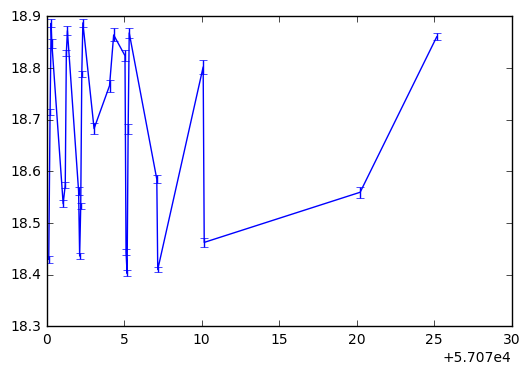

Blind15A_46_N21_1305_2506 RRLYR

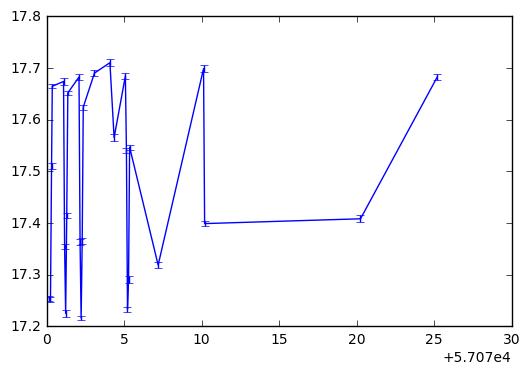

In [33]:
for idx in rrlyr.index[:2]:
    print '\r', idx, table_15.loc[idx, 'Var_Type'],
    field, CCD, X, Y = re.findall(r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', idx)[0]
    try:
        time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD,X, Y,extract=False)
    except:
        print 'fail during LC read'
        continue
       
    plt.errorbar(time, mag, yerr=err)
    plt.show()

### Put the spectra in the influxDB

In [75]:
from influxdb import InfluxDBClient
import json
import time

# client.create_database('example')
client = InfluxDBClient('localhost', 8086, 'root', 'root', 'HiTS-test')

t_0 = time.time()
t_idx = 0
for idx in rrlyr.index[:10]:
    print '\r', idx,
    field, CCD, X, Y = re.findall(r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', idx)[0]
    try:
        mjd, mag, err, time2, mag2, err2 = give_me_lc(field, CCD,X, Y,extract=False)
    except:
        print 'fail during LC read'
        continue
    label = table_15.loc[idx, 'Var_Type']
    ra    = table_15.loc[idx, 'raMedian']
    dec   = table_15.loc[idx, 'decMedian']
    print type(label)
    points = []
    for t,m,e in zip(mjd,mag,err):
        t_idx += 1
        mjd_idx = t * 10**8
        pnt = {"measurement": label,
                "time"      : mjd_idx.astype(int),
                "fields":{"ID" : idx,
                          "RA" : ra,
                          "DEC": dec,
                          "MJD": t,
                          "mag": m,
                          "err": e,
                         }
              }
        points.append(pnt)
    client.write_points(points)
    del points
t_1 = time.time()
write_time = (t_1-t_0)
print("write time: %f" % write_time)

Blind15A_27_S6_1014_3281 <type 'str'>
Blind15A_46_N21_1305_2506 <type 'str'>
Blind15A_16_N10_0157_3879 <type 'str'>
Blind15A_38_S8_1526_0166 <type 'str'>
Blind15A_04_N16_0184_3344 <type 'str'>
Blind15A_44_N26_0810_2931 <type 'str'>
Blind15A_07_S12_0784_1183 <type 'str'>
Blind15A_17_S8_1781_0906 <type 'str'>
Blind15A_17_S13_1286_1068 <type 'str'>
Blind15A_34_N28_1932_0653 <type 'str'>
write time: 5.037064


In [71]:
result = client.query('select * from RRLYR')
print result

ResultSet({'(u'RRLYR', None)': [{u'MJD': 57070.1112247, u'err': 0.00330205562943, u'RA': 137.162160634, u'mag': 17.382351102, u'time': u'1970-01-01T01:35:07.01112247Z', u'DEC': -0.646970846367, u'ID': u'Blind15A_04_N16_0184_3344'}, {u'MJD': 57070.1152628, u'err': 0.00382514617578, u'RA': 139.937350669, u'mag': 16.7149287696, u'time': u'1970-01-01T01:35:07.01152628Z', u'DEC': -0.0324677778884, u'ID': u'Blind15A_07_S12_0784_1183'}, {u'MJD': 57070.1273042, u'err': 0.00558301931117, u'RA': 145.286063811, u'mag': 16.9759571197, u'time': u'1970-01-01T01:35:07.01273042Z', u'DEC': 1.52119874566, u'ID': u'Blind15A_16_N10_0157_3879'}, {u'MJD': 57070.128634, u'err': 0.0044509474549, u'RA': 144.858439483, u'mag': 18.2250656799, u'time': u'1970-01-01T01:35:07.0128634Z', u'DEC': -0.0683401337446, u'ID': u'Blind15A_17_S13_1286_1068'}, {u'MJD': 57070.1420036, u'err': 0.00657203645583, u'RA': 150.410389274, u'mag': 18.4296000945, u'time': u'1970-01-01T01:35:07.01420036Z', u'DEC': 0.23557942399, u'ID': 